## DATA EXTRACTION

STEP1
- Code to extract and save movie-wise shen-parcellated fMRI data from the Human Connectome Project (HCP)'s social task dataset. The dataset has fMRI data from 1048 subjects.
- Task info: subjects watched 20s animations that were labelled by the experimenters and previous studies as "mental" and "random" - 5 stimuli/condition. Participants were asked to rate stimuli as mental, random or unsure after the end of the animation, 
- Our analysis of the behavioral data showed that although participants' reports in general agreed with the expter-assigned labels this was not always the case
- The fMRI data we obtained from the HCP online repository has been already preprocessed by them (motion corrected, unwarping, spatial normalization to MNI space etc. details in Barch et al, 2013, NI).
- Further, voxel-wise data has already been parcellated into 268 ROIs/nodes spanning the whole brain as per Shen parcellation.
- Here we begin by (1) removing subjects with missing runs, delayed stimulus presentations etc., and then move on to (2) temporally preprocess timecourses (Z-score normalization, trialwise baseline-correction), (3) isolate data from individual trials (t-x to t+28+y, where t is the first TR for a single trial/movie, and 28 volumes were acquired in 20s, and x/y are the nr of TRs before/after the movie)


TERMS/ABBREVIATIONS USED INTERCHANGEABLY:
- movie <-> trial
- mental <-> social <-> "yes" response/responder
- random <-> non-social <-> "no" response/responder
- nodes <-> regions of interest <-> ROIs
- subjects <-> participants <-> subs

@CODE REVIEWER: COMMENTS TO YOU START WITH "@CODE REVIEWER"

REKHA VARRIER, OCTOBER 2021

### Importing packages and parcellated fMRI data, exploring datatypes etc.

In [1]:
# import packages, check folders
#%reset
from pathlib import Path
from datetime import datetime
import os
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time

%matplotlib inline

working_dir = '/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code'

print('current directory:\n',working_dir)
path = Path(working_dir)
parent_folder = path.parent
data_file_loc = os.path.join(parent_folder,'data') # to store data we extract later in this notebook

fmri_dir = "/Users/f0053cz/Documents/HCP_SOCIALforRekha-001/HCP_SOCIALforRekha"
os.chdir(fmri_dir)
print('\nchanged current directory to:\n', fmri_dir)

''' # don't really need these, they're there just to explore data storage
folderName = os.path.join(fmri_dir,'indiv_data') # fMRI data is stored here
print("\nnumber of folders=",len(os.listdir(folderName)))

subj_folders = [i for i in os.listdir(folderName)]
print('subject folders',subj_folders[:10]) #beh data n=1051'''

current directory:
 /Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code

changed current directory to:
 /Users/f0053cz/Documents/HCP_SOCIALforRekha-001/HCP_SOCIALforRekha


' # don\'t really need these, they\'re there just to explore data storage\nfolderName = os.path.join(fmri_dir,\'indiv_data\') # fMRI data is stored here\nprint("\nnumber of folders=",len(os.listdir(folderName)))\n\nsubj_folders = [i for i in os.listdir(folderName)]\nprint(\'subject folders\',subj_folders[:10]) #beh data n=1051'

In [2]:
# setting default fontsizes for plots

s=16 # CHANGE FONTSIZE HERE

plt.rc('font', size=s) #controls default text size
plt.rc('axes', titlesize=s) #fontsize of the title
plt.rc('axes', labelsize=s) #fontsize of the x and y labels
plt.rc('xtick', labelsize=s) #fontsize of the x tick labels
plt.rc('ytick', labelsize=s) #fontsize of the y tick labels
plt.rc('legend', fontsize=s) #fontsize of the legend
#import matplotlib as mpl
#mpl.rcParams['font.weight']= 'normal'


From the plot above, it looks like timecourses are more similar across time within a node than across nodes - make sense - it could reflect firing props of neurons within that node or anything else typical of an roi

Now let's get working on the dataset. First we extract the data per run

## Extracting timecourses, subject indices

In [3]:
#extract fMRI data and subject names
f_RL = h5py.File("shen268_timecourses_RL.hdf5", "r") # dims: (subj*timecourseperrun*node), run 1 - first five movies
f_LR = h5py.File("shen268_timecourses_LR.hdf5", "r") # run 2 - next/last 5 movies

dat = {}
dat["run1"] = np.array(f_RL['shen268_timecourses'])
dat["run2"] = np.array(f_LR['shen268_timecourses'])
print('type(dat):',type(dat))

# subject list
subj_list = {}
subj_list["run1"] = [x.decode('utf8') for x in list(f_RL['subjlist'])] #RL--> order of subjects for run 1
subj_list["run2"] = [x.decode('utf8') for x in list(f_LR['subjlist'])] #LR
# Python string method decode() decodes the string using the codec registered for encoding.
# It defaults to the default string encoding.
print('type(subj_list):',type(subj_list))


type(dat): <class 'dict'>
type(subj_list): <class 'dict'>


## Exploring timecourses

In [4]:
# movies were presented in two runs, in the same order and at the same onset times (i.e., no jitter added)

vid_names = {}
vid_names["run1"] = ["COAXING-B", "BILLIARD-A", "DRIFTING-A", "Fishing", "Random mechanical"]#RL
vid_names["run2"] = ["Scaring", "SEDUCING-B", "STAR-A", "SURPRISING-B", "TENNIS-A"]#LR

vid_cat = {} # video category (mental/random or social/nonsocial)
vid_cat["run1"] = [1,0,0,1,0] # 1:mental,0: random
vid_cat["run2"] = [1,1,0,1,0]

## Import behavioral data

- Before extracting the data, let's also identify the behavioral data and remove impossibly short RTs (indicative of accidental button presses etc.)

In [5]:
#extract behavioral data, remove impossibly quick responses RT < 100ms
# approx 10 responses per subject, hence number of rows ~=10k

beh_data = pd.read_csv("/Users/f0053cz/Documents/HCP_SOCIALforRekha-001/HCP_SOCIALforRekha/hcp_social_behav_for_ddm_stim-coding.csv")
rtmin = 0.1 # threshold for impossibly short RTs

print('nrows before=', beh_data.shape)
print("total subjects before=",len(np.unique(beh_data['subj_idx'])))

beh_data_old = beh_data
beh_data= beh_data[beh_data["rt"]>=rtmin] # remove trials with RT<.1
print('\nnrows after=', beh_data.shape)
print("total subjects after=",len(np.unique(beh_data['subj_idx'])))
#print(np.where(beh_data.index == subj_shortRT[0]))
beh_data.head()

nrows before= (10149, 5)
total subjects before= 1051

nrows after= (9950, 5)
total subjects after= 1050


,subj_idx,stim,movie,rt,response
0,168745,Mental,Scaring.AVI,1.252,1
1,168745,Mental,SEDUCING-B.AVI,0.578,1
2,168745,Random,STAR-A.AVI,1.643,0
3,168745,Mental,SURPRISING-B.AVI,1.082,1
4,168745,Random,TENNIS-A.AVI,1.232,0


In [6]:
# import notebook from code 1_2_regressors
[timepts_indiv_movie,vid_start_rel_tr] = np.load(os.path.join(data_file_loc,'Video_TRs.npy'),allow_pickle=True)
# [timepts_indiv_movie,vid_start_rel_tr] 
#vid_start_rel_tr
print([len(i) for i in timepts_indiv_movie])
vid_start_rel_tr

[49, 56, 56, 56, 56, 49, 56, 56, 56, 56]


array([7, 14, 14, 14, 14, 7, 14, 14, 14, 14], dtype=object)

## Subject-wise preprocessing:
- finally coming to the main step
- Extraction of relevant TRs for each subject, normalizing and baseline-correcting it and store in a 4D array
- code below for both with run-wise norm. and trial-wise norm. (for different analyses later)

@CODE REVIEWER: FROM HERE ON, I'D LIKE YOU TO PLEASE VERIFY THAT THERE ARE NO ERRORS PLEASE

In [7]:
# setting common variables for both types of preprocessing 

nsubj = 1053 #1053 # total 1053 subs, but only 1048 will be in the final data (others have only one run or delayed stimulus presentation)
nnodes = 268 #268
#tr0_ind = 3 # timept at which t=0 for video
ntimepts = 56
nmovies = 10
n_init_TRs_to_delete = 5

In [8]:
from scipy.signal import detrend

### 1. RUN-wise normalisation (Zscore) and then baseline correction.

In [9]:

# run-wise normalization is more useful when comparing responses for the same movie. Within-trial comparison is 
# more useful for across-movie comparisons

start = time.time()

responses = np.empty((nsubj, nmovies))
responses[:] = np.nan # initialise responses with NaN
responses_rt = np.empty((nsubj, nmovies))
responses_rt[:] = np.nan # initialise responses with NaN
sub_id_all = [] # to save subject ID
Ynorm = np.empty((nsubj, nnodes, ntimepts, nmovies))
Ynorm[:] = np.nan
timecourses = np.empty((nsubj,nnodes,269,2))
timecourses[:] = np.nan

sub_ind = -1 # to store index of subject ID
for s1 in np.arange(0,1):#nsubj):
    if s1 % 50 == 0: # printing occasional status updates
        now = time.time()
        print(f'subj:{s1},time elapsed:{(now - start)/60:.2f}mins')
    curr_subj = subj_list['run1'][s1] # Subject ID, e.g. '126628'
    if curr_subj != '105620': # this subject had a delayed stimulus presentation (removing for ease atm)
        try:
            s2 = subj_list['run2'].index(curr_subj)
            # see if the subject has data for run 2, if not don't count them (execution would go to except segment)

            # proceeding if sub has data for both runs
            curr_subj = int(curr_subj)
            sub_id_all.append(curr_subj) # save subject ID

            sub_ind += 1 # for each sub with both runs

            for vid_no in range(10): # to store responses for each subject who has both runs
                run = 'run1' if vid_no < 5 else 'run2'
                vidName = vid_names[run][vid_no%5]
                vidName = '.'.join((vidName,'AVI')) # add .avi

                row = (beh_data['subj_idx'] == curr_subj) & (beh_data['movie'] == vidName)
                #print(len(np.where(row)[0]))
                if len(np.where(row)[0]) == 1: # unique row for that subj and movie
                    responses[sub_ind,vid_no] = beh_data.loc[row,'response']
                    responses_rt[sub_ind,vid_no] = beh_data.loc[row,'rt']
                elif len(np.where(row)[0]) > 1:
                    print('error!!!!') # error in behavioral data selection

            # preproc step 1: within-run normalize each node
            for node in range(nnodes):
                tc_run1 = dat['run1'][s1,n_init_TRs_to_delete:,node] # data after removing first 5 TRs, so 274-5 TRs/run
                tc_run2 = dat['run2'][s2,n_init_TRs_to_delete:,node] 

                #runSlope[sub_ind,node,0] = np.polyfit(np.arange(tc_run1.shape[0]),tc_run1,1)[0]
                # linearly for the run, and save the slope for the run
                #runSlope[sub_ind,node,1] = np.polyfit(np.arange(tc_run2.shape[0]),tc_run2,1)[0]

                tc_run1 = detrend(tc_run1) # removing linear trends
                tc_run2 = detrend(tc_run2)
                tc_run1 = stats.zscore(tc_run1) # Z-score normalize values
                tc_run2 = stats.zscore(tc_run2)
                #tc_run1 = (tc_run1 - np.nanmean(tc_run1))/np.nanstd(tc_run1)
                #tc_run2 = (tc_run2 - np.nanmean(tc_run2))/np.nanstd(tc_run2)

                timecourses[sub_ind,node,:,0] = tc_run1
                timecourses[sub_ind,node,:,1] = tc_run2

                # baseline-correct each trial or movie
                for vid_no in np.arange(0,nmovies): 
                    #run = 'run1' if vid_no < 5 else 'run2'
                    image_TRs = timepts_indiv_movie[vid_no] # TRs within run corresponding to vidno
                    Y = tc_run1[image_TRs] if vid_no<5 else tc_run2[image_TRs] # timecourse for a trial/vid_no

                    # baseline correction
                    if vid_no % 5 == 0:
                        Ynorm[sub_ind, node, :49, vid_no] = Y - Y[vid_start_rel_tr[vid_no]] #baseline correct and assign to a 4D array
                    else:
                        Ynorm[sub_ind, node, :  , vid_no] = Y - Y[vid_start_rel_tr[vid_no]] #baseline correct and assign to a 4D array

        except: # print error message if both runs aren't present (or there's another error in try)
                print(['only one subject for ind ',s1,', subjID:',curr_subj])

Ynorm = Ynorm[:sub_ind+1,:,:,:] # remove unused rows
responses = responses[:sub_ind+1,:]
responses_rt = responses_rt[:sub_ind+1,:]
timecourses = timecourses[:sub_ind+1,:,:,:]
#runSlope = runSlope[:sub_ind+1,:,:]

if sub_ind == 1047:
    np.save(os.path.join(data_file_loc,'timecourses_run_norm',f'timecourse-all-movies_zscorenorm'), Ynorm) # save timecourses
    np.save(os.path.join(data_file_loc,'responses.npy'), responses) # save beh responses
    np.save(os.path.join(data_file_loc,'responses_rt.npy'), responses_rt) # save beh responses
    np.save(os.path.join(data_file_loc,'timecourses.npy'), timecourses) # save run timecourses (for all movie LMs)
    np.save(os.path.join(data_file_loc,'sub_ID_all.npy'), sub_id_all) # save run timecourses (for all movie LMs)
print('\n\nData saved on/at:',datetime.now()) # cell run at




subj:0,time elapsed:0.02mins
subj:50,time elapsed:0.17mins
subj:100,time elapsed:0.30mins
subj:150,time elapsed:0.44mins
subj:200,time elapsed:0.56mins
subj:250,time elapsed:0.70mins
subj:300,time elapsed:0.82mins
subj:350,time elapsed:0.95mins
subj:400,time elapsed:1.08mins
['only one subject for ind ', 438, ', subjID:', '175540']
subj:450,time elapsed:1.22mins
['only one subject for ind ', 453, ', subjID:', '748662']
subj:500,time elapsed:1.34mins
subj:550,time elapsed:1.47mins
subj:600,time elapsed:1.60mins
subj:650,time elapsed:1.72mins
subj:700,time elapsed:1.85mins
['only one subject for ind ', 710, ', subjID:', '248238']
['only one subject for ind ', 729, ', subjID:', '103010']
subj:750,time elapsed:1.97mins
subj:800,time elapsed:2.10mins
subj:850,time elapsed:2.23mins
subj:900,time elapsed:2.35mins
subj:950,time elapsed:2.48mins
subj:1000,time elapsed:2.60mins
subj:1050,time elapsed:2.73mins


Data saved on/at: 2021-12-20 09:54:46.454380


In [11]:
len(sub_id_all)

1048

### 2. TRIAL-wise normalisation (Zscore) and then baseline correction.

In [43]:
l_task = 28

In [44]:
# trial-wise normalization is more useful when comparing responses across movies
# takes over 10 mins!!

start = time.time()

Ynorm = np.empty((nsubj, nnodes, ntimepts, nmovies))
Ynorm[:] = np.nan

sub_ind = -1 # to store index of subject ID
for s1 in np.arange(0,nsubj):
    if s1 % 50 == 0: # printing occasional status updates
        now = time.time()
        print(f'subj:{s1},time elapsed:{(now - start)/60:.2f}mins')
    curr_subj = subj_list['run1'][s1] # Subject ID, e.g. '126628'
    if curr_subj != '105620': # this subject had a delayed stimulus presentation (removing for ease atm)
        try:
            s2 = subj_list['run2'].index(curr_subj)
            # see if the subject has data for run 2, if not don't count them (execution would go to except segment)

            # proceeding if sub has data for both runs
            curr_subj = int(curr_subj)
            #sub_id_all.append(curr_subj)
            sub_ind += 1 # for each sub with both runs

            for vid_no in range(10): # to store responses for each subject who has both runs
                run = 'run1' if vid_no < 5 else 'run2'
                vidName = vid_names[run][vid_no%5]
                vidName = '.'.join((vidName,'AVI')) # add .avi

                row = (beh_data['subj_idx'] == curr_subj) & (beh_data['movie'] == vidName)
                #print(len(np.where(row)[0]))
                if len(np.where(row)[0]) > 1:
                    print('error!!!!') # error in behavioral data selection

            # preproc step 1: within-run normalize each node
            for node in range(nnodes):
                tc_run1 = dat['run1'][s1,n_init_TRs_to_delete:,node] # data after removing first 5 TRs, so 274-5 TRs/run
                tc_run2 = dat['run2'][s2,n_init_TRs_to_delete:,node] 

                #runSlope[sub_ind,node,0] = np.polyfit(np.arange(tc_run1.shape[0]),tc_run1,1)[0]
                # linearly for the run, and save the slope for the run
                #runSlope[sub_ind,node,1] = np.polyfit(np.arange(tc_run2.shape[0]),tc_run2,1)[0]

                tc_run1 = detrend(tc_run1) # removing linear trends
                tc_run2 = detrend(tc_run2)
                #tc_run1 = stats.zscore(tc_run1) # Z-score normalize values
                #tc_run2 = stats.zscore(tc_run2)
                #tc_run1 = (tc_run1 - np.nanmean(tc_run1))/np.nanstd(tc_run1)
                #tc_run2 = (tc_run2 - np.nanmean(tc_run2))/np.nanstd(tc_run2)

                # normalize and baseline-correct each trial or movie
                for vid_no in np.arange(0,nmovies): 
                    run = 'run1' if vid_no < 5 else 'run2'
                    image_TRs = timepts_indiv_movie[vid_no] # TRs within run corresponding to vidno
                    Y = tc_run1[image_TRs] if run == 'run1' else tc_run2[image_TRs] # timecourse for a trial/vid_no
                    Y = stats.zscore(Y)
                    #vid_inds = np.arange(vid_start_rel_tr[vid_no],vid_start_rel_tr[vid_no]+l_task)
                    #Y[vid_inds] = stats.zscore(Y[vid_inds])
                    
                    # baseline correction
                    if vid_no % 5 == 0:
                        Ynorm[sub_ind,node,:49,vid_no] = Y - Y[vid_start_rel_tr[vid_no]] #baseline correct and assign to a 4D array
                    else:
                        Ynorm[sub_ind,node,:,vid_no]   = Y - Y[vid_start_rel_tr[vid_no]] #baseline correct and assign to a 4D array

        except: # print error message if both runs aren't present (or there's another error in try)
                print(['only one subject for ind ',s1,', subjID:',curr_subj])

Ynorm = Ynorm[:sub_ind+1,:,:,:] # remove unused rows

if sub_ind == 1047:
    np.save(os.path.join(data_file_loc,'timecourses_trial_norm',f'timecourse-all-movies_zscorenorm'), Ynorm) # save timecourses

print('\n\nData saved on/at:',datetime.now()) # cell run at




subj:0,time elapsed:0.01mins
subj:50,time elapsed:0.31mins
subj:100,time elapsed:0.62mins
subj:150,time elapsed:0.91mins
subj:200,time elapsed:1.20mins
subj:250,time elapsed:1.46mins
subj:300,time elapsed:1.77mins
subj:350,time elapsed:2.04mins
subj:400,time elapsed:2.31mins
['only one subject for ind ', 438, ', subjID:', '175540']
subj:450,time elapsed:2.56mins
['only one subject for ind ', 453, ', subjID:', '748662']
subj:500,time elapsed:2.81mins
subj:550,time elapsed:3.07mins
subj:600,time elapsed:3.37mins
subj:650,time elapsed:3.65mins
subj:700,time elapsed:3.91mins
['only one subject for ind ', 710, ', subjID:', '248238']
['only one subject for ind ', 729, ', subjID:', '103010']
subj:750,time elapsed:4.20mins
subj:800,time elapsed:4.48mins
subj:850,time elapsed:4.75mins
subj:900,time elapsed:5.04mins
subj:950,time elapsed:5.29mins
subj:1000,time elapsed:5.57mins
subj:1050,time elapsed:5.85mins


Data saved on/at: 2021-12-02 16:05:16.376830


In [46]:
# trial-wise normalization is more useful when comparing responses across movies
# takes over 10 mins!!
# tr0-7:tr28+14

start = time.time()

Ynorm = np.empty((nsubj, nnodes, 49, nmovies))
Ynorm[:] = np.nan

sub_ind = -1 # to store index of subject ID
for s1 in np.arange(0,nsubj):
    if s1 % 50 == 0: # printing occasional status updates
        now = time.time()
        print(f'subj:{s1},time elapsed:{(now - start)/60:.2f}mins')
    curr_subj = subj_list['run1'][s1] # Subject ID, e.g. '126628'
    if curr_subj != '105620': # this subject had a delayed stimulus presentation (removing for ease atm)
        try:
            s2 = subj_list['run2'].index(curr_subj)
            # see if the subject has data for run 2, if not don't count them (execution would go to except segment)

            # proceeding if sub has data for both runs
            curr_subj = int(curr_subj)
            #sub_id_all.append(curr_subj)
            sub_ind += 1 # for each sub with both runs

            for vid_no in range(10): # to store responses for each subject who has both runs
                run = 'run1' if vid_no < 5 else 'run2'
                vidName = vid_names[run][vid_no%5]
                vidName = '.'.join((vidName,'AVI')) # add .avi

                row = (beh_data['subj_idx'] == curr_subj) & (beh_data['movie'] == vidName)
                #print(len(np.where(row)[0]))
                if len(np.where(row)[0]) > 1:
                    print('error!!!!') # error in behavioral data selection

            # preproc step 1: within-run normalize each node
            for node in range(nnodes):
                tc_run1 = dat['run1'][s1,n_init_TRs_to_delete:,node] # data after removing first 5 TRs, so 274-5 TRs/run
                tc_run2 = dat['run2'][s2,n_init_TRs_to_delete:,node] 

                #runSlope[sub_ind,node,0] = np.polyfit(np.arange(tc_run1.shape[0]),tc_run1,1)[0]
                # linearly for the run, and save the slope for the run
                #runSlope[sub_ind,node,1] = np.polyfit(np.arange(tc_run2.shape[0]),tc_run2,1)[0]

                tc_run1 = detrend(tc_run1) # removing linear trends
                tc_run2 = detrend(tc_run2)
                #tc_run1 = stats.zscore(tc_run1) # Z-score normalize values
                #tc_run2 = stats.zscore(tc_run2)
                #tc_run1 = (tc_run1 - np.nanmean(tc_run1))/np.nanstd(tc_run1)
                #tc_run2 = (tc_run2 - np.nanmean(tc_run2))/np.nanstd(tc_run2)

                # normalize and baseline-correct each trial or movie
                for vid_no in np.arange(0,nmovies): 
                    run = 'run1' if vid_no < 5 else 'run2'                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
                    image_TRs = timepts_indiv_movie[vid_no] # TRs within run corresponding to vidno
                    if vid_no % 5 != 0:
                        image_TRs = image_TRs[7:]
                    Y = tc_run1[image_TRs] if run == 'run1' else tc_run2[image_TRs] # timecourse for a trial/vid_no
                    #Y = stats.zscore(Y)
                    Y = (Y-np.nanmean(Y))/(np.nanmax(Y)-np.nanmin(Y))
                    #vid_inds = np.arange(vid_start_rel_tr[vid_no],vid_start_rel_tr[vid_no]+l_task)
                    #Y[vid_inds] = stats.zscore(Y[vid_inds])
                    
                    Ynorm[sub_ind,node,:,vid_no] = Y - Y[7] #baseline correct and assign to a 4D array

        except: # print error message if both runs aren't present (or there's another error in try)
                print(['only one subject for ind ',s1,', subjID:',curr_subj])

Ynorm = Ynorm[:sub_ind+1,:,:,:] # remove unused rows

if sub_ind == 1047:
    np.save(os.path.join(data_file_loc,'timecourses_trial_norm',f'timecourse-all-movies_zscorenorm_maxmindiv_tr0-7_to_tr28+14.npy'), Ynorm) # save timecourses

print('\n\nData saved on/at:',datetime.now()) # cell run at


subj:0,time elapsed:0.01mins
subj:50,time elapsed:0.21mins
subj:100,time elapsed:0.41mins
subj:150,time elapsed:0.61mins
subj:200,time elapsed:0.81mins
subj:250,time elapsed:1.01mins
subj:300,time elapsed:1.21mins
subj:350,time elapsed:1.41mins
subj:400,time elapsed:1.64mins
['only one subject for ind ', 438, ', subjID:', '175540']
subj:450,time elapsed:1.86mins
['only one subject for ind ', 453, ', subjID:', '748662']
subj:500,time elapsed:2.13mins
subj:550,time elapsed:2.36mins
subj:600,time elapsed:2.58mins
subj:650,time elapsed:2.79mins
subj:700,time elapsed:3.02mins
['only one subject for ind ', 710, ', subjID:', '248238']
['only one subject for ind ', 729, ', subjID:', '103010']
subj:750,time elapsed:3.22mins
subj:800,time elapsed:3.43mins
subj:850,time elapsed:3.67mins
subj:900,time elapsed:3.89mins
subj:950,time elapsed:4.11mins
subj:1000,time elapsed:4.30mins
subj:1050,time elapsed:4.49mins


Data saved on/at: 2021-12-02 16:15:28.300084


In [47]:
# trial-wise normalization is more useful when comparing responses across movies
# takes over 10 mins!!
# max min div

start = time.time()

Ynorm = np.empty((nsubj, nnodes, ntimepts, nmovies))
Ynorm[:] = np.nan

sub_ind = -1 # to store index of subject ID
for s1 in np.arange(0,nsubj):
    if s1 % 50 == 0: # printing occasional status updates
        now = time.time()
        print(f'subj:{s1},time elapsed:{(now - start)/60:.2f}mins')
    curr_subj = subj_list['run1'][s1] # Subject ID, e.g. '126628'
    if curr_subj != '105620': # this subject had a delayed stimulus presentation (removing for ease atm)
        try:
            s2 = subj_list['run2'].index(curr_subj)
            # see if the subject has data for run 2, if not don't count them (execution would go to except segment)

            # proceeding if sub has data for both runs
            curr_subj = int(curr_subj)
            #sub_id_all.append(curr_subj)
            sub_ind += 1 # for each sub with both runs

            for vid_no in range(10): # to store responses for each subject who has both runs
                run = 'run1' if vid_no < 5 else 'run2'
                vidName = vid_names[run][vid_no%5]
                vidName = '.'.join((vidName,'AVI')) # add .avi

                row = (beh_data['subj_idx'] == curr_subj) & (beh_data['movie'] == vidName)
                #print(len(np.where(row)[0]))
                if len(np.where(row)[0]) > 1:
                    print('error!!!!') # error in behavioral data selection

            # preproc step 1: within-run normalize each node
            for node in range(nnodes):
                tc_run1 = dat['run1'][s1,n_init_TRs_to_delete:,node] # data after removing first 5 TRs, so 274-5 TRs/run
                tc_run2 = dat['run2'][s2,n_init_TRs_to_delete:,node] 

                #runSlope[sub_ind,node,0] = np.polyfit(np.arange(tc_run1.shape[0]),tc_run1,1)[0]
                # linearly for the run, and save the slope for the run
                #runSlope[sub_ind,node,1] = np.polyfit(np.arange(tc_run2.shape[0]),tc_run2,1)[0]

                tc_run1 = detrend(tc_run1) # removing linear trends
                tc_run2 = detrend(tc_run2)
                #tc_run1 = stats.zscore(tc_run1) # Z-score normalize values
                #tc_run2 = stats.zscore(tc_run2)
                #tc_run1 = (tc_run1 - np.nanmean(tc_run1))/np.nanstd(tc_run1)
                #tc_run2 = (tc_run2 - np.nanmean(tc_run2))/np.nanstd(tc_run2)

                # normalize and baseline-correct each trial or movie
                for vid_no in np.arange(0,nmovies): 
                    run = 'run1' if vid_no < 5 else 'run2'
                    image_TRs = timepts_indiv_movie[vid_no] # TRs within run corresponding to vidno
                    
                    Y = tc_run1[image_TRs] if run == 'run1' else tc_run2[image_TRs] # timecourse for a trial/vid_no
                    #Y = stats.zscore(Y)
                    Y = (Y-np.nanmean(Y))/(np.nanmax(Y)-np.nanmin(Y))
                    #vid_inds = np.arange(vid_start_rel_tr[vid_no],vid_start_rel_tr[vid_no]+l_task)
                    #Y[vid_inds] = stats.zscore(Y[vid_inds])
                    
                    # baseline correction
                    if vid_no % 5 == 0:
                        Ynorm[sub_ind,node,:49,vid_no] = Y - Y[vid_start_rel_tr[vid_no]] #baseline correct and assign to a 4D array
                    else:
                        Ynorm[sub_ind,node,:,vid_no]   = Y - Y[vid_start_rel_tr[vid_no]] #baseline correct and assign to a 4D array

        except: # print error message if both runs aren't present (or there's another error in try)
                print(['only one subject for ind ',s1,', subjID:',curr_subj])

Ynorm = Ynorm[:sub_ind+1,:,:,:] # remove unused rows

if sub_ind == 1047:
    np.save(os.path.join(data_file_loc,'timecourses_trial_norm',f'timecourse-all-movies_zscorenorm_maxmindiv'), Ynorm) # save timecourses

print('\n\nData saved on/at:',datetime.now()) # cell run at


subj:0,time elapsed:0.01mins
subj:50,time elapsed:0.22mins
subj:100,time elapsed:0.42mins
subj:150,time elapsed:0.63mins
subj:200,time elapsed:0.85mins
subj:250,time elapsed:1.06mins
subj:300,time elapsed:1.27mins
subj:350,time elapsed:1.48mins
subj:400,time elapsed:1.70mins
['only one subject for ind ', 438, ', subjID:', '175540']
subj:450,time elapsed:1.90mins
['only one subject for ind ', 453, ', subjID:', '748662']
subj:500,time elapsed:2.13mins
subj:550,time elapsed:2.36mins
subj:600,time elapsed:2.58mins
subj:650,time elapsed:2.78mins
subj:700,time elapsed:3.02mins
['only one subject for ind ', 710, ', subjID:', '248238']
['only one subject for ind ', 729, ', subjID:', '103010']
subj:750,time elapsed:3.24mins
subj:800,time elapsed:3.48mins
subj:850,time elapsed:3.70mins
subj:900,time elapsed:3.92mins
subj:950,time elapsed:4.15mins
subj:1000,time elapsed:4.37mins
subj:1050,time elapsed:4.58mins


Data saved on/at: 2021-12-02 16:51:54.645532


In [ ]:
# trial-wise normalization is more useful when comparing responses across movies
# takes over 10 mins!!
# timecourse analysis
tr0_ind = 3 
start = time.time()
ntimepts_tc = l_task+tr0_ind
Ynorm = np.empty((nsubj, nnodes, ntimepts_tc, nmovies))
Ynorm[:] = np.nan

sub_ind = -1 # to store index of subject ID
for s1 in np.arange(0,nsubj):
    if s1 % 50 == 0: # printing occasional status updates
        now = time.time()
        print(f'subj:{s1},time elapsed:{(now - start)/60:.2f}mins')
    curr_subj = subj_list['run1'][s1] # Subject ID, e.g. '126628'
    if curr_subj != '105620': # this subject had a delayed stimulus presentation (removing for ease atm)
        try:
            s2 = subj_list['run2'].index(curr_subj)
            # see if the subject has data for run 2, if not don't count them (execution would go to except segment)

            # proceeding if sub has data for both runs
            curr_subj = int(curr_subj)
            #sub_id_all.append(curr_subj)
            sub_ind += 1 # for each sub with both runs

            for vid_no in range(10): # to store responses for each subject who has both runs
                run = 'run1' if vid_no < 5 else 'run2'
                vidName = vid_names[run][vid_no%5]
                vidName = '.'.join((vidName,'AVI')) # add .avi

                row = (beh_data['subj_idx'] == curr_subj) & (beh_data['movie'] == vidName)
                #print(len(np.where(row)[0]))
                if len(np.where(row)[0]) > 1:
                    print('error!!!!') # error in behavioral data selection

            # preproc step 1: within-run normalize each node
            for node in range(nnodes):
                tc_run1 = dat['run1'][s1,n_init_TRs_to_delete:,node] # data after removing first 5 TRs, so 274-5 TRs/run
                tc_run2 = dat['run2'][s2,n_init_TRs_to_delete:,node] 

                tc_run1 = detrend(tc_run1) # removing linear trends
                tc_run2 = detrend(tc_run2)
                
                # normalize and baseline-correct each trial or movie
                for vid_no in np.arange(0,nmovies): 
                    run = 'run1' if vid_no < 5 else 'run2'
                    image_TRs = timepts_indiv_movie[vid_no]
                    image_TRs = image_TRs[vid_start_rel_tr[vid_no]-tr0_ind:vid_start_rel_tr[vid_no]+l_task] # TRs within run corresponding to vidno
                    Y = tc_run1[image_TRs] if run == 'run1' else tc_run2[image_TRs] # timecourse for a trial/vid_no
                    #Y = stats.zscore(Y)
                    Y = (Y-np.nanmean(Y[tr0_ind:]))/np.nanstd(Y[tr0_ind:])#vid_inds = np.arange(vid_start_rel_tr[vid_no],vid_start_rel_tr[vid_no]+l_task)
                    #Y[vid_inds] = stats.zscore(Y[vid_inds])
                    
                    # baseline correction
                    if vid_no % 5 == 0:
                        Ynorm[sub_ind,node,:,vid_no] = Y - Y[tr0_ind] #baseline correct and assign to a 4D array
                    else:
                        Ynorm[sub_ind,node,:,vid_no]   = Y - Y[tr0_ind] #baseline correct and assign to a 4D array

        except: # print error message if both runs aren't present (or there's another error in try)
                print(['only one subject for ind ',s1,', subjID:',curr_subj])

Ynorm = Ynorm[:sub_ind+1,:,:,:] # remove unused rows

if sub_ind == 1047:
    np.save(os.path.join(data_file_loc,'timecourses_trial_norm',f'timecourse-all-movies_zscorenorm_tcanalysis'), Ynorm) # save timecourses

print('\n\nData saved on/at:',datetime.now()) # cell run at




In [10]:
# trial-wise normalization is more useful when comparing responses across movies
# takes over 10 mins!!
tr0_ind = 3 
start = time.time()
ntimepts_tc = l_task+tr0_ind
Ynorm = np.empty((nsubj, nnodes, ntimepts_tc, nmovies))
Ynorm[:] = np.nan

sub_ind = -1 # to store index of subject ID
for s1 in np.arange(0,nsubj):
    if s1 % 50 == 0: # printing occasional status updates
        now = time.time()
        print(f'subj:{s1},time elapsed:{(now - start)/60:.2f}mins')
    curr_subj = subj_list['run1'][s1] # Subject ID, e.g. '126628'
    if curr_subj != '105620': # this subject had a delayed stimulus presentation (removing for ease atm)
        try:
            s2 = subj_list['run2'].index(curr_subj)
            # see if the subject has data for run 2, if not don't count them (execution would go to except segment)

            # proceeding if sub has data for both runs
            curr_subj = int(curr_subj)
            #sub_id_all.append(curr_subj)
            sub_ind += 1 # for each sub with both runs

            for vid_no in range(10): # to store responses for each subject who has both runs
                run = 'run1' if vid_no < 5 else 'run2'
                vidName = vid_names[run][vid_no%5]
                vidName = '.'.join((vidName,'AVI')) # add .avi

                row = (beh_data['subj_idx'] == curr_subj) & (beh_data['movie'] == vidName)
                #print(len(np.where(row)[0]))
                if len(np.where(row)[0]) > 1:
                    print('error!!!!') # error in behavioral data selection

            # preproc step 1: within-run normalize each node
            for node in range(nnodes):
                tc_run1 = dat['run1'][s1,n_init_TRs_to_delete:,node] # data after removing first 5 TRs, so 274-5 TRs/run
                tc_run2 = dat['run2'][s2,n_init_TRs_to_delete:,node] 

                tc_run1 = detrend(tc_run1) # removing linear trends
                tc_run2 = detrend(tc_run2)
                
                # normalize and baseline-correct each trial or movie
                for vid_no in np.arange(0,nmovies): 
                    run = 'run1' if vid_no < 5 else 'run2'
                    image_TRs = timepts_indiv_movie[vid_no]
                    image_TRs = image_TRs[vid_start_rel_tr[vid_no]-tr0_ind:vid_start_rel_tr[vid_no]+l_task] # TRs within run corresponding to vidno
                    Y = tc_run1[image_TRs] if run == 'run1' else tc_run2[image_TRs] # timecourse for a trial/vid_no
                    #Y = stats.zscore(Y)
                    #Y = (Y-np.nanmean(Y[tr0_ind:]))/np.nanstd(Y[tr0_ind:])#vid_inds = np.arange(vid_start_rel_tr[vid_no],vid_start_rel_tr[vid_no]+l_task)
                    Y = (Y-np.nanmean(Y[tr0_ind:]))/(np.nanmax(Y[tr0_ind:])-np.nanmin(Y[tr0_ind:]))#vid_inds = np.arange(vid_start_rel_tr[vid_no],vid_start_rel_tr[vid_no]+l_task)
                    #Y[vid_inds] = stats.zscore(Y[vid_inds])
                    
                    # baseline correction
                    if vid_no % 5 == 0:
                        Ynorm[sub_ind,node,:,vid_no] = Y - Y[tr0_ind] #baseline correct and assign to a 4D array
                    else:
                        Ynorm[sub_ind,node,:,vid_no]   = Y - Y[tr0_ind] #baseline correct and assign to a 4D array

        except: # print error message if both runs aren't present (or there's another error in try)
                print(['only one subject for ind ',s1,', subjID:',curr_subj])

Ynorm = Ynorm[:sub_ind+1,:,:,:] # remove unused rows

if sub_ind == 1047:
    np.save(os.path.join(data_file_loc,'timecourses_trial_norm',f'timecourse-all-movies_zscorenorm_tcanalysis_maxmindiv'), Ynorm) # save timecourses

print('\n\nData saved on/at:',datetime.now()) # cell run at




subj:0,time elapsed:0.00mins
subj:50,time elapsed:0.20mins
subj:100,time elapsed:0.40mins
subj:150,time elapsed:0.58mins
subj:200,time elapsed:0.77mins
subj:250,time elapsed:0.96mins
subj:300,time elapsed:1.21mins
subj:350,time elapsed:1.42mins
subj:400,time elapsed:1.63mins
['only one subject for ind ', 438, ', subjID:', '175540']
subj:450,time elapsed:1.82mins
['only one subject for ind ', 453, ', subjID:', '748662']
subj:500,time elapsed:2.01mins
subj:550,time elapsed:2.19mins
subj:600,time elapsed:2.39mins
subj:650,time elapsed:2.58mins
subj:700,time elapsed:2.77mins
['only one subject for ind ', 710, ', subjID:', '248238']
['only one subject for ind ', 729, ', subjID:', '103010']
subj:750,time elapsed:2.96mins
subj:800,time elapsed:3.15mins
subj:850,time elapsed:3.35mins
subj:900,time elapsed:3.53mins
subj:950,time elapsed:3.73mins
subj:1000,time elapsed:3.93mins
subj:1050,time elapsed:4.13mins


Data saved on/at: 2021-11-30 10:46:44.738851


In [14]:
Ynorm.shape

(1048, 268, 31, 10)

## sanity check of trialwise data

In [34]:
Ynorm[:5,0,:,0].shape

(5, 56)

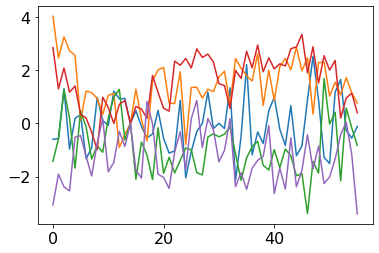

In [16]:
Ynorm =  np.load(os.path.join(data_file_loc,'timecourses_trial_norm',f'timecourse-all-movies_zscorenorm.npy'))
plt.plot(Ynorm[:5,0,:,1].T)

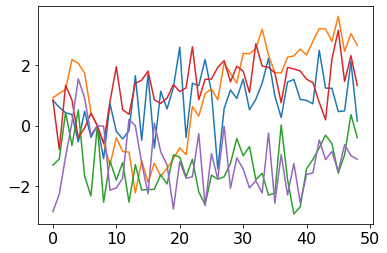

In [35]:
Ynorm =  np.load(os.path.join(data_file_loc,'timecourses_run_norm',f'timecourse-all-movies_zscorenorm.npy'))
plt.plot(Ynorm[:5,0,:,0].T)

In [36]:
timecourses = np.load(os.path.join(data_file_loc,'timecourses.npy'))
timecourses[0,0,:5,:] # see if values are distinct

array([[ 0.00364855,  0.66507549],
       [-0.2293776 , -0.76939139],
       [-0.40624693,  1.50187307],
       [-0.46695373, -0.18351192],
       [-1.36892794, -0.92859621]])

## Is there a linear trend?
- this step was done when the above code did not contain a detrending step.
- don't need to run it now that the data has already been detrended

Ttest_1sampResult(statistic=-49.98950663403359, pvalue=0.0)
nr. of nodes with a slope sig different from 0 in run 1:
210
nr. of nodes with a slope sig different from 0 in run 2
228
Slope run 1: mean: -0.03899181115291593 Ttest_1sampResult(statistic=-49.98950663403359, pvalue=0.0)
Slope run 2: mean: -0.07717801757289106 Ttest_1sampResult(statistic=-95.89548049424342, pvalue=0.0)


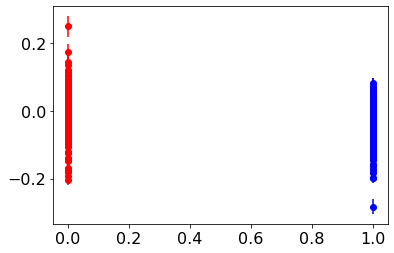

In [28]:
# no need to run this now

plt.figure(1)
plt.errorbar(np.zeros((268,)),np.nanmedian(runSlope[:,:,0],axis=0),stats.sem(runSlope[:,:,0],axis=0),
             marker ='o',color = 'r',ls = 'None')
plt.errorbar(np.ones((268,)),np.nanmedian(runSlope[:,:,1],axis=0),stats.sem(runSlope[:,:,1],axis=0),
             marker ='o',color = 'b',ls = 'None')
print(stats.ttest_1samp(np.ndarray.flatten(runSlope[:,:,0]),0))

print('nr. of nodes with a slope sig different from 0 in run 1:')
print(sum([1 if stats.ttest_1samp(runSlope[:,n,0],0)[1]<.05 else 0 for n in range(268)]))

print('nr. of nodes with a slope sig different from 0 in run 2')    
print(sum([1 if stats.ttest_1samp(runSlope[:,n,1],0)[1]<.05 else 0 for n in range(268)]))


print('Slope run 1: mean:',np.nanmean(np.ndarray.flatten(runSlope[:,:,0])),stats.ttest_1samp(np.ndarray.flatten(runSlope[:,:,0]),0))
print('Slope run 2: mean:',np.nanmean(np.ndarray.flatten(runSlope[:,:,1])),stats.ttest_1samp(np.ndarray.flatten(runSlope[:,:,1]),0))

# example detrending
plt.figure(2)
from scipy.signal import detrend
x = dat['run1'][0,n_init_TRs_to_delete:,0]
plt.figure(1, figsize = (25,5))
plt.plot(x)
plt.plot(detrend(x,type= 'linear'))

- Looks like the slope in all nodes is sig < zero, although the magnitude is very small. So we should detrend before normalizing etc.
- ^^**this has been done already**

In [ ]:
# this code snippet helped determine that the first 5 TRs of a run need to be removed. 
# # this has been done already, so can be run as a sanity check, but is optional
# first 5 TRs of the run

plt.figure(1,figsize =(15,10))
for run in range(2):
    plt.subplot(2,1,run+1)
    plt.title(f'Run{run+1}',fontsize =24)
    for n in np.arange(0,268):
        plt.errorbar(range(10), np.nanmedian(all_runs_z[:,n,:10,run],axis=0),
                     stats.sem(all_runs_z[:,n,:10,run],axis=0,nan_policy='omit'))
                     #color = 'k',alpha = .1)
    ymin,ymax = plt.ylim()
    for i in range(5):
        plt.axvspan(vid_onsets_imagenr[i],vid_onsets_imagenr[i]+28, color = 'red', alpha = .1, label = 'stim')  #vertical shading

    plt.xlim(0,10)
plt.tight_layout()



## Extra code

### code reviewer: stop here

In [36]:
def my_moving_window(x, window=3, FUN=np.mean):
    """
    Calculates a moving estimate for a signal

    Args:
      x (numpy.ndarray): a vector array of size N
      window (int): size of the window, must be a positive integer
      FUN (function): the function to apply to the samples in the window

    Returns:
      (numpy.ndarray): a vector array of size N, containing the moving
      average of x, calculated with a window of size window

    There are smarter and faster solutions (e.g. using convolution) but this
    function shows what the output really means. This function skips NaNs, and
    should not be susceptible to edge effects: it will simply use
    all the  available samples, which means that close to the edges of the
    signal or close to NaNs, the output will just be based on fewer samples. By
    default, this function will apply a mean to the samples in the window, but
    this can be changed to be a max/min/median or other function that returns a
    single numeric value based on a sequence of values.
    """

    # if data is a matrix, apply filter to each row:
    if len(x.shape) == 2:
        output = np.zeros(x.shape)
        for rown in range(x.shape[0]):
            output[rown, :] = my_moving_window(x[rown, :],
                                             window=window,
                                             FUN=FUN)
        return output

    # make output array of the same size as x:
    output = np.zeros(x.size)

    # loop through the signal in x
    for samp_i in range(x.size):

        values = []

        # loop through the window:
        for wind_i in range(int(1 - window), 1):

            if ((samp_i + wind_i) < 0) or (samp_i + wind_i) > (x.size - 1):
                # out of range
                continue

            # sample is in range and not nan, use it:
            if not(np.isnan(x[samp_i + wind_i])):
                values += [x[samp_i + wind_i]]

        # calculate the mean in the window for this point in the output:
        output[samp_i] = FUN(values)

    return output

In [ ]:
def preproc(Y):
    # function to normalise timecourses and baseline correct them
    #Y = my_moving_window(Y)
    Y = Y - np.min(Y)
    Y = Y/np.max(Y)
    Y = Y - Y[0]
    return Y,Y[0]

## Max-min normalization

In [ ]:
# RUN-wise normalisation (max min) and then baseline correction wrt the means of t = -3 to -1.

# seeing tif maxmin norm is better

# preprocess Y, store (1) moviewise timecourses, (2) baseline normY and beh responses across movies
# save preprocessed timecourses for each movie in a single file
start = time.time()

#y0 = np.zeros((nsubj,nmovies,nnodes))
#responses = np.empty((nsubj, nmovies))
#responses[:] = np.nan # initialise responses with NaN
sub_id_all = []
Ynorm = np.zeros((nsubj, nnodes, ntimepts, nmovies))
plot_fig = 1
if plot_fig:
    plt.figure(1,figsize=(10,8))
sub_ind = -1
for s1 in np.arange(0,nsubj):
    if s1 % 50 == 0: # printing occasional status updates
        now = time.time()
        print('subj:',s1,', time elapsed:', np.round((now - start)/60,2),'mins')
    curr_subj = subj_list['run1'][s1] # Subject ID, e.g. '126628'
    if curr_subj != '105620':
        try:
            s2 = subj_list['run2'].index(curr_subj)
            # see if the subject has data for run 2, if not don't count them (execution would go to except segment)

            # proceed if sub has data for both runs
            curr_subj = int(curr_subj)
            sub_id_all.append(curr_subj)
            sub_ind += 1 # for each sub with run1 and 2

            for vid_no in range(10): # to store responses for each subject who has both runs
                run = 'run1' if vid_no < 5 else 'run2'
                #vidName = vid_names[run][vid_no%5]
                #vidName = '.'.join((vidName,'AVI')) # add .avi

                #row = (beh_data['subj_idx'] == curr_subj) & (beh_data['movie'] == vidName)
                #if len(np.where(row)[0]) == 1: # unique row for that subj and movie
                #    responses[sub_ind,vid_no] = beh_data.loc[row,'response']
                #if len(np.where(row)[0]) > 1:
                #    print('error!!!!')

            # preproc step 1: within-run normalize each node
            for node in range(nnodes):
                tc_run1 = dat['run1'][s1,:,node] # 274 TRs/run
                tc_run2 = dat['run2'][s2,:,node] 

                #tc_run1 = stats.zscore(tc_run1) # Z-score normalize values
                #tc_run2 = stats.zscore(tc_run2)
                
                ## YET TO ADD DETRENDING##

                tc_run1 -= min(tc_run1[5:]) # alternate option: to use max-min normalization
                tc_run1 = np.divide(tc_run1,np.max(tc_run1[5:])) # all values within 0-1
                tc_run2 -= min(tc_run2[5:])
                tc_run2 = np.divide(tc_run2,np.max(tc_run2[5:])) # all values within 0-1
                # why not just exclude the first 5 points? because this way
                # can retain the same indices, ut data unaffected by initial random 
                # values which may skew the normalized values
                
                if sub_ind < 100:
                    all_runs_maxmin[sub_ind,node,:,0] = tc_run1
                    all_runs_maxmin[sub_ind,node,:,1] = tc_run2

                # baseline-correct each trial or movie
                for vid_no in np.arange(0,nmovies): 

                    run = 'run1' if vid_no < 5 else 'run2'
                    image_TRs = timepts_indiv_movie[vid_no] # TRs within run corresponding to vidno
                    Y = tc_run1[image_TRs] if run == 'run1' else tc_run2[image_TRs] # timecourse for a trial/vid_no
                    if plot_fig:
                        if node == 0:
                            if (vid_no in [0,5]) and (sub_ind == 0) and (node==0):
                                #print(np.nanmean(Y[0:2]))
                                #print(Y)
                                plt.subplot(2,1,1)
                                plt.plot(tc_run1 if run == 'run1' else tc_run2) # plot a run for a single subject
                            #plt.subplot(2,5,vid_no+1)
                            #plt.plot(Y, marker ='o')

                    #Y = Y-np.nanmean(Y[0:tr0_ind]) #baseline correct using the mean of the 3 TRs prior to stimulus onset
                    Y = Y-Y[tr0_ind] #baseline correct using the mean of the 3 TRs prior to stimulus onset
                    Ynorm[sub_ind,node,:,vid_no] = Y # assign to a 4D array
                    if (vid_no == 0) and (sub_ind == 0) and (node==0): # plot the first tc to illustrate
                        plt.subplot(2,2,3)
                        plt.plot(Ynorm[sub_ind,node,:,vid_no])
                        runs_to_plot.append(tc_run1)

        except: # print error message if both runs aren't present (or there's another error in try)
                print(['only one subject for ind ',s1,', subjID:',curr_subj])

Ynorm = Ynorm[:sub_ind+1,:,:,:] # remove unused rows
#responses = responses[:sub_ind+1,:]

if plot_fig:
    plt.tight_layout()
    
if nsubj == 1053:
    np.save(os.path.join(data_file_loc,'timecourses_run_norm',f'timecourse-all-movies_maxminnorm'), Ynorm) # save timecourses
    #np.save(os.path.join(data_file_loc,'responses.npy'), responses) # save beh responses

print('\n\nData saved on/at:',datetime.now()) # cell run at



In [ ]:
# figure for one-on-one meeting on 17.08.21
x = np.zeros((181,))
for i in range(len(vid_onsets_in_sec)):
    x[vid_onsets_in_sec[i]:vid_onsets_in_sec[i]+20] = 1
    
for i in range(2):
    plt.figure(i,figsize = (30,5))
    #plt.plot(x,marker = 'o', label = 'video block (secs)')
    x_ims = [tr*i for i in range(int(np.ceil(181/tr)))]
    x_ims
    #for i in vid_onsets_imagenr:
    #    plt.vlines(x_ims[i-5:i+5],-1,1)
    
    if i==0:
        plt.plot(runs_to_plot[0],label = 'zscore')
    else:
        plt.plot(runs_to_plot[1],label = 'max-min norm')
    ymin,ymax = plt.ylim()
    plt.vlines(vid_onsets_imagenr,ymin,ymax,color = 'r', label = 'onset TR (prev)')
    plt.vlines((vid_onsets_imagenr+28),ymin,ymax,color = 'r', ls = 'dashed',label = 'offset TR (prev)')
    plt.vlines((vid_onsets_imagenr),ymin,ymax,color = 'magenta', label = 'onset TR0')
    plt.vlines((vid_onsets_imagenr+28),ymin,ymax,color = 'magenta', ls = 'dashed', label = 'offset TR28')
    
    plt.xticks(fontsize =20)
    plt.yticks([0,1],fontsize =20)
    #for ind in range(len(x_ims[:100])):
    #    plt.text(x_ims[ind],5,ind,rotation=90,fontsize = 20)
    #plt.ylim(-.2,2)
    #plt.xlim(0,75)
    plt.xlabel('Time in secs',fontsize =20)
    plt.ylabel('Video = 1, Rest =0',fontsize =20)
    plt.legend(fontsize =20, bbox_to_anchor=(0.25, -.1))

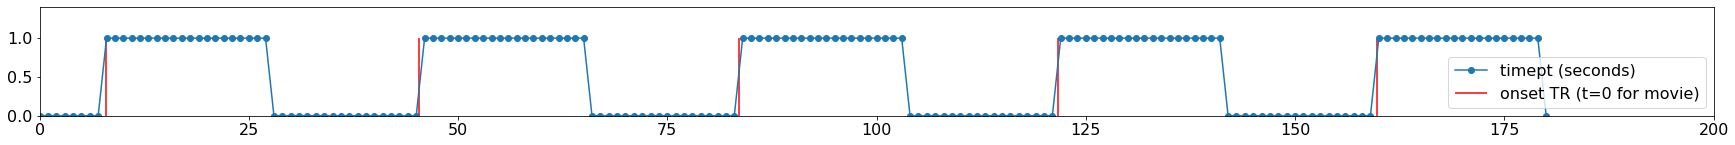

In [75]:
# Visualizing a run
x = np.zeros((181,))
for i in range(len(vid_onsets_in_sec)):
    x[int(vid_onsets_in_sec[i]):int(vid_onsets_in_sec[i])+20] = 1
plt.figure(1,figsize = (30,2))
plt.plot(x,marker = 'o', label = 'timept (seconds)')
x_ims = [tr*i for i in range(int(np.ceil(181/tr)))]
x_ims
'''#vertical lines show 5 TRs before and 5 after the onset time for each video
for i in vid_onsets_imagenr:
    i = int(i)
    plt.vlines(x_ims[i-5:i+5],-1,1) # vertical lines 5 TRs before and after
'''
plt.vlines(vid_onsets_imagenr*tr,-1,1,color = 'r', label = 'onset TR (t=0 for movie)')
#plt.vlines(vid_onsets_imagenr*tr-1,-1,1,color = 'magenta', label = 'onset TR-1')

#for i in range(len(x_ims)):
#    plt.text(x_ims[i],1.1,i,rotation=90)
plt.ylim(0,1.4)
plt.xlim(0,200)
plt.legend(loc = 'lower right',fontsize = 16)